In [2]:
import numpy as np
from FlagRep import FlagRep
from matplotlib import pyplot as plt

import scipy.io as sio

from tqdm import tqdm

# Trying with HS data

In [3]:


# Load the hyperspectral image and ground truth
data = sio.loadmat('../data/indian_pines/Indian_pines_corrected.mat')['indian_pines_corrected'] 
labels = sio.loadmat('../data/indian_pines/Indian_pines_gt.mat')['indian_pines_gt']  # Shape: (145, 145)


print(data.shape)

(145, 145, 200)


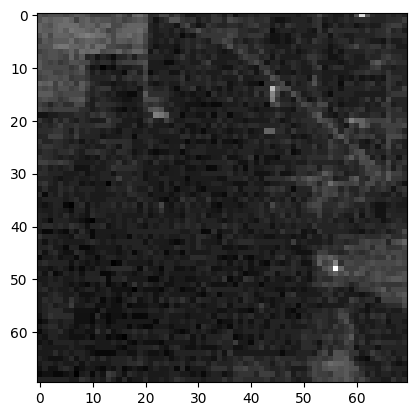

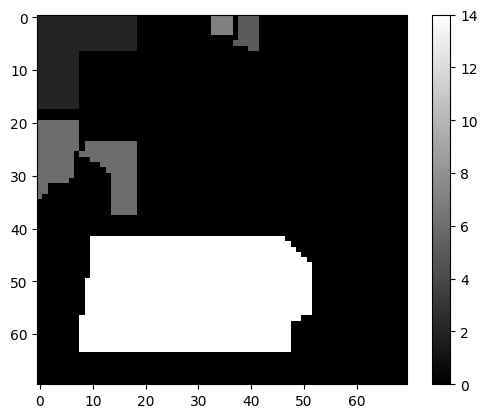

In [7]:
# patch_data, patch_labels, Aset = extract_patches(data, labels, 11, np.arange(16))

# D = patch_data[0]
# D.shape
plt.figure()
plt.imshow(data[-70:,-70:,2], cmap = 'grey')

plt.figure()
plt.imshow(labels[-70:,-70:], cmap = 'grey')
plt.colorbar()

In [8]:
np.where(labels!=0)

(array([  0,   0,   0, ..., 143, 143, 143]),
 array([ 0,  1,  2, ..., 30, 31, 32]))

In [9]:
D = np.reshape(data[:70,:70,:], (-1,200))
# D = np.reshape(data/data.max(), (-1,200))

In [10]:
np.linalg.matrix_rank(D), D.shape, len(D)

(np.int64(200), (4900, 200), 4900)

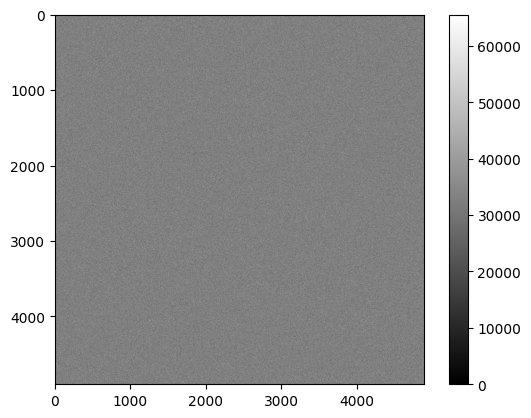

In [11]:
plt.imshow(D @ D.T, cmap = 'grey')
plt.colorbar()

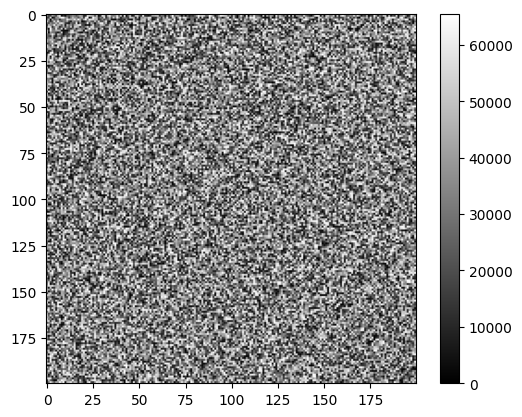

In [12]:
plt.imshow(D.T @ D, cmap = 'grey')
plt.colorbar()

Correlation Matrix:
[[1.         0.34711042 0.3729944  ... 0.3757029  0.38535294 0.3902903 ]
 [0.34711042 1.         0.86431582 ... 0.79744407 0.78156561 0.7710552 ]
 [0.3729944  0.86431582 1.         ... 0.77959546 0.75768705 0.74266218]
 ...
 [0.3757029  0.79744407 0.77959546 ... 1.         0.99051755 0.98373641]
 [0.38535294 0.78156561 0.75768705 ... 0.99051755 1.         0.99376419]
 [0.3902903  0.7710552  0.74266218 ... 0.98373641 0.99376419 1.        ]]


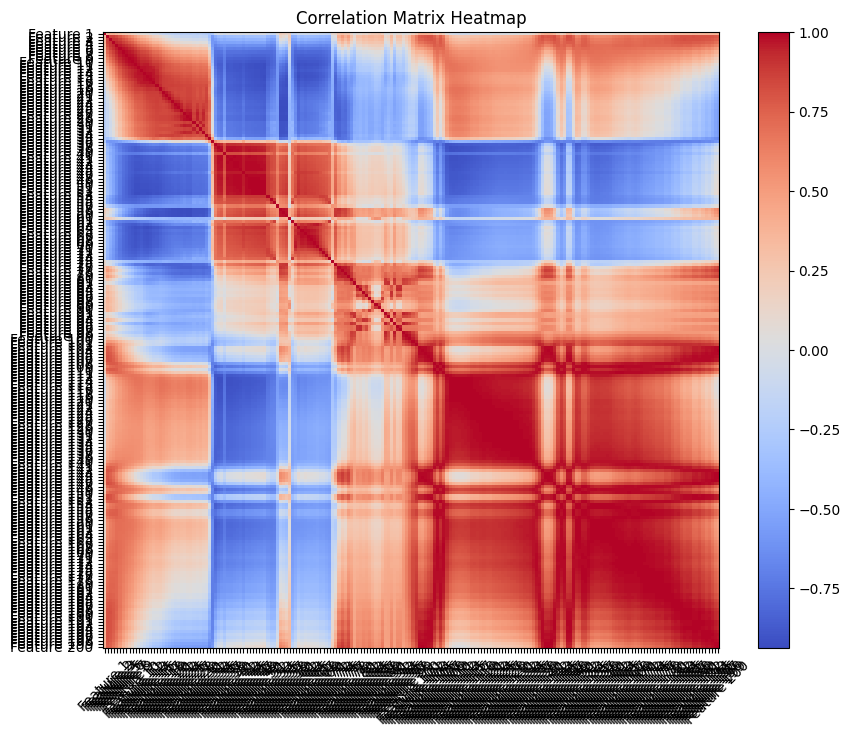

In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

n_samples, n_features  = D.shape

# Normalize the data
X_normalized = normalize(D)

# Create a DataFrame for easier handling
df = pd.DataFrame(X_normalized, columns=[f'Feature {i+1}' for i in range(n_features)])

# Generate the correlation matrix
correlation_matrix = np.array(df.corr())

# Output the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix Heatmap')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(ticks=np.arange(n_features), labels=df.columns, rotation=45)
plt.yticks(ticks=np.arange(n_features), labels=df.columns)
plt.show()

/tmp/ipykernel_3053189/555422073.py:9: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(1-correlation_matrix, method='ward')  # You can choose other methods like 'single', 'complete', etc.


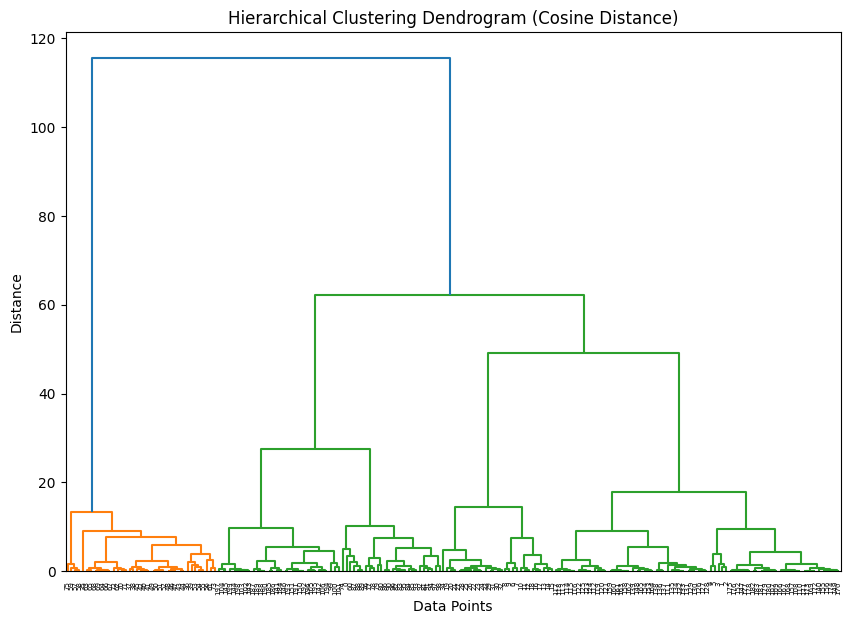

In [14]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt


# Perform hierarchical clustering
Z = linkage(1-correlation_matrix, method='ward')  # You can choose other methods like 'single', 'complete', etc.

# Define the number of clusters
num_clusters = 3

# Assign cluster memberships
clusters = fcluster(Z, num_clusters, criterion='maxclust')


# Plotting the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Cosine Distance)')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()



In [15]:
[len(np.where(clusters==i)[0]) for i in range(1,4)]

[39, 58, 103]

In [16]:
Aset = [ np.where(clusters==3)[0], 
        np.concatenate((np.where(clusters==3)[0],np.where(clusters==2)[0])), 
        np.concatenate((np.where(clusters==3)[0],np.where(clusters==2)[0],np.where(clusters==1)[0]))]

In [17]:
B = np.hstack([D[:,np.where(clusters==3)[0]],D[:,np.where(clusters==2)[0]], D[:,np.where(clusters==1)[0]]])

Correlation Matrix:
[[ 1.          0.86431582  0.86508847 ... -0.41407219 -0.43337585
   0.0397956 ]
 [ 0.86431582  1.          0.90757902 ... -0.50025855 -0.51383473
  -0.04201589]
 [ 0.86508847  0.90757902  1.         ... -0.58049816 -0.58085648
  -0.14672122]
 ...
 [-0.41407219 -0.50025855 -0.58049816 ...  1.          0.77495327
   0.65266361]
 [-0.43337585 -0.51383473 -0.58085648 ...  0.77495327  1.
   0.57719434]
 [ 0.0397956  -0.04201589 -0.14672122 ...  0.65266361  0.57719434
   1.        ]]


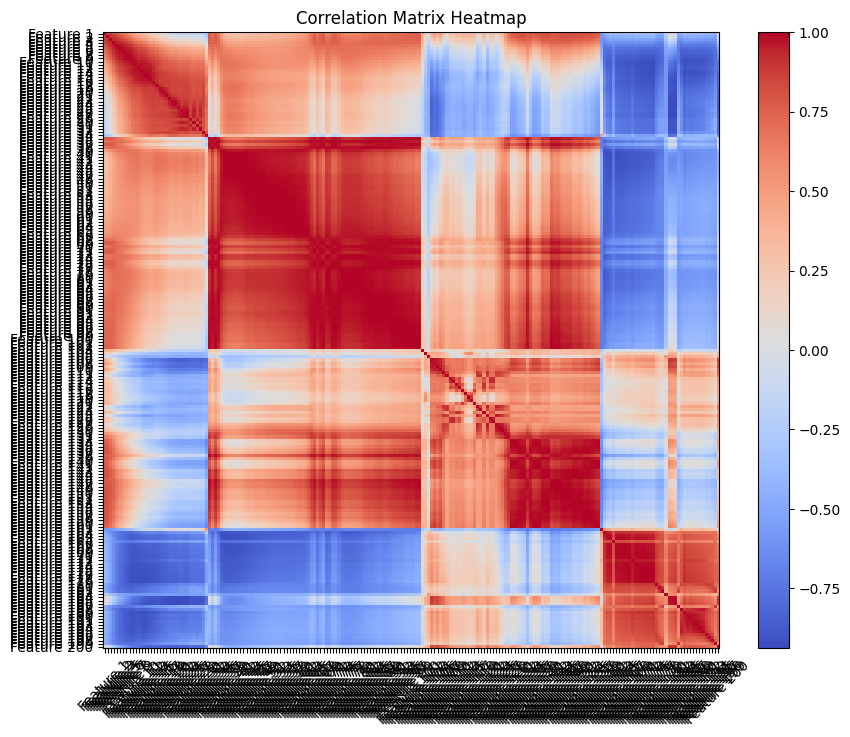

In [18]:
# Normalize the data
X_normalized = normalize(B)

# Create a DataFrame for easier handling
df = pd.DataFrame(X_normalized, columns=[f'Feature {i+1}' for i in range(n_features)])

# Generate the correlation matrix
correlation_matrix = np.array(df.corr())

# Output the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix Heatmap')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(ticks=np.arange(n_features), labels=df.columns, rotation=45)
plt.yticks(ticks=np.arange(n_features), labels=df.columns)
plt.show()

[ 2 28 64]


np.float64(1372989.3258827948)

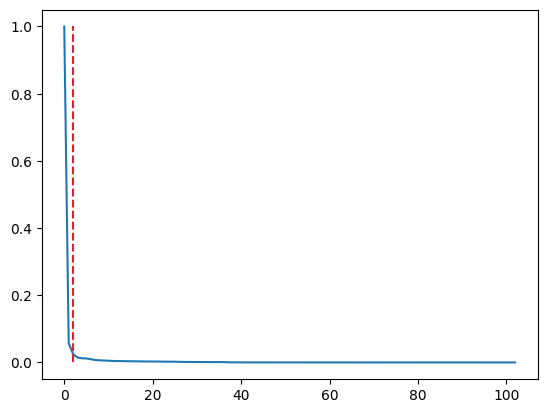

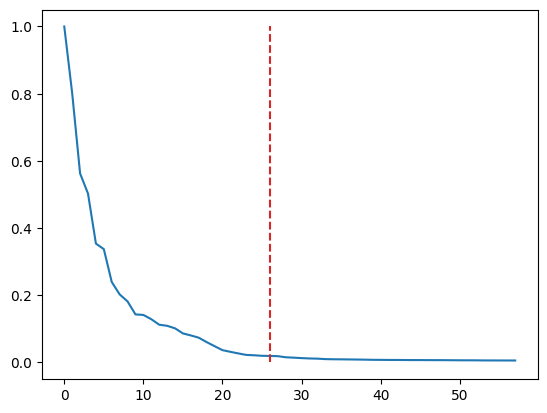

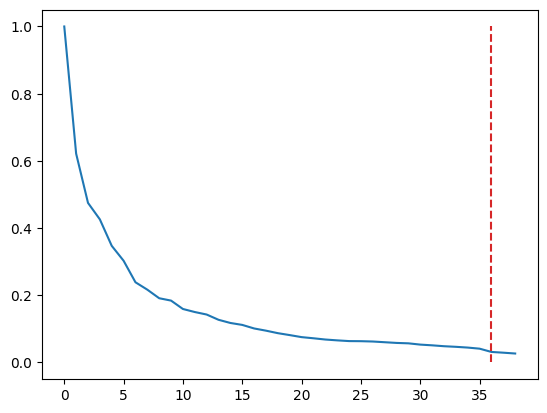

In [22]:

my_flag_rep = FlagRep(Aset = Aset, solver = 'svd', plot_eigs = True, eps_rank=  .999)
X, R = my_flag_rep.decompose(D)
print(my_flag_rep.flag_type())
np.sum(np.linalg.norm(X @ R - B, axis = 1)**2)/len(B)

In [23]:
U,S,_ = np.linalg.svd(D, full_matrices = False)
# S = S/S.max()
# s_diff = np.abs(np.diff(S))
# n_vecs = np.sum(s_diff >= 1e-3)
n_vecs = 64
U = U[:,:n_vecs]
np.sum(np.linalg.norm(U @ U.T @ D - D, axis = 1)**2)/len(D)

np.float64(43913.94097836821)

In [34]:
def flag_diagnostic(D, p, step_size, Aset_end):
    the_As = []
    errs = []
    ns = []
    for n_1 in range(step_size,p,step_size): #loop through every feature combination between {1,2,...,n_1} \subset {1,...,220}
        As = [np.arange(n_1)]+Aset_end
        the_As.append(As)

        my_flag_rep = FlagRep(Aset = As)
        Q,R = my_flag_rep.decompose(D)
        print(my_flag_rep.flag_type())

        errs.append(np.linalg.norm(Q @ R - D))
        ns.append(n_1)

    plt.figure()
    plt.plot(ns, errs)

    return ns[np.argmin(errs)]


[ 20 200]
[ 40 200]
[ 60 200]
[ 80 200]
[100 200]
[120 200]
[140 200]
[160 200]
[180 200]


100

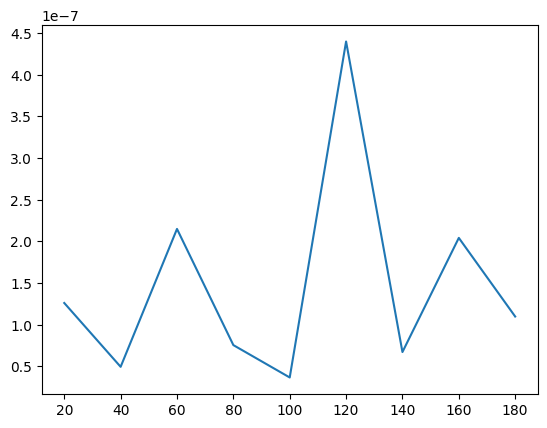

In [35]:
flag_diagnostic(D, 200, 20, [np.arange(200)])

[ 20 100 200]
[ 40 100 200]
[ 60 100 200]
[ 80 100 200]


40

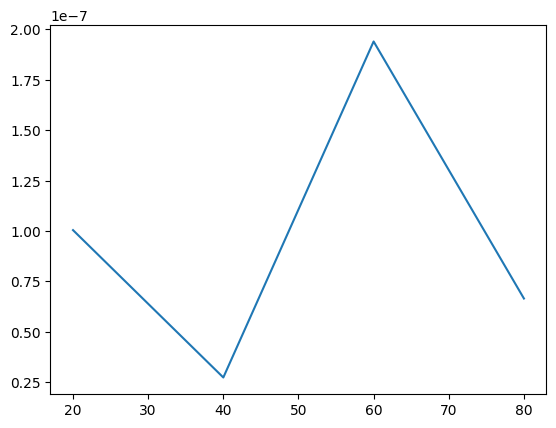

In [36]:
flag_diagnostic(D, 100, 20, [np.arange(100),np.arange(200)])

In [54]:
def ordered_partitions_of_size_k(n, k):
    result = []

    # Helper function to recursively find partitions
    def partition(n, k, current_partition):
        if k == 0:
            if n == 0:
                result.append(current_partition)
            return

        for i in range(1, n - k + 2):  # Ensure enough remaining space for remaining parts
            partition(n - i, k - 1, current_partition + [i])

    # Call the recursive partition function
    partition(n, k, [])
    
    return result

# Example usage for n = 5 and k = 2
n = 20
k = 3
partitions = ordered_partitions_of_size_k(n, k)
flag_types = [np.cumsum(p) for p in partitions]

In [55]:
len(flag_types)

171

In [56]:

errs = []
for f_type in tqdm(flag_types):
    my_flag_rep = FlagRep(Aset = [np.arange(40),np.arange(100),np.arange(200)], flag_type = f_type)
    Q,R = my_flag_rep.decompose(D)
    errs.append(np.linalg.norm(Q @ R - D))
print(flag_types[np.argmin(errs)])

100%|██████████| 171/171 [05:05<00:00,  1.78s/it]

[10 19 20]


In [57]:
U = np.linalg.svd(D)[0][:,:20]
pca_err = np.linalg.norm(U @ U.T @ D - D)

In [83]:
my_flag_rep = FlagRep(Aset = [np.arange(100),np.arange(200)], flag_type = [19,20])
Q,R = my_flag_rep.decompose(D)
dumb_err = np.linalg.norm(Q @ R - D)

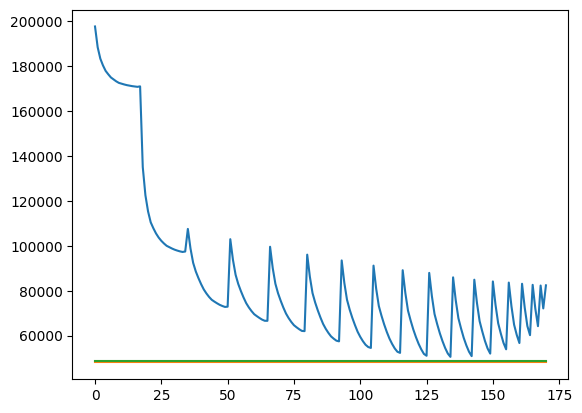

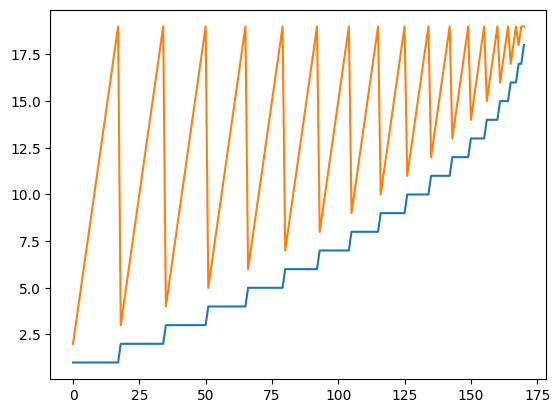

In [84]:
plt.figure()
plt.plot(errs)
plt.plot([pca_err]*len(errs))
plt.plot([dumb_err]*len(errs))
plt.figure()
plt.plot([f[0] for f in flag_types])
plt.plot([f[1] for f in flag_types])
# plt.plot([f[2] for f in flag_types])

In [60]:
import sys
sys.path.append('./scratchwork')

from PSA_utils import *

In [78]:
models = [p+[200-n] for p in partitions]
eigval, eigvec = evd(D.T)
baseline_weights = eigvec[:,:n]
true_fl_type, _ = model_selection_eval(D.T, eigval, models, criterion="bic")
fl_type = list(np.cumsum(true_fl_type)[:-1])
fl_type

[np.int64(2), np.int64(5), np.int64(20)]

# Outlier Detection